# 時系列分析結果の詳細解釈ガイド

## 目的
このノートブックでは、前回実施したLME銅3M時系列分析の結果を**一つずつ詳しく解釈**し、
**トレーディングにどう活用するか**を具体的に説明します。

## 解釈する項目
1. **移動平均・移動標準偏差の解釈**
2. **ACF/PACFチャートの読み方**
3. **ADF検定結果の意味**
4. **差分系列の特性**
5. **トレーディングへの実践的応用**

In [1]:
# まず前回の分析結果を再現するために必要なライブラリをインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import os
from dotenv import load_dotenv

try:
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False

warnings.filterwarnings('ignore')
load_dotenv()

plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]

print("ライブラリ読み込み完了")
print(f"statsmodels利用可能: {STATSMODELS_AVAILABLE}")

ライブラリ読み込み完了
statsmodels利用可能: True


## Step 1: データの再読み込みと確認

In [2]:
# データベース接続とデータ読み込み
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# データ読み込み
try:
    engine = create_engine(connection_string)
    
    query = """
    SELECT 
        trade_date,
        last_price as close_price
    FROM lme_copper_prices
    WHERE price_type = '3M_OUTRIGHT'
    AND last_price IS NOT NULL
    ORDER BY trade_date
    """
    
    df = pd.read_sql_query(query, engine)
    engine.dispose()
    
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df.set_index('trade_date', inplace=True)
    df['close_price'] = pd.to_numeric(df['close_price'], errors='coerce')
    
    price_series = df['close_price'].dropna()
    
    print(f"✓ データ読み込み完了: {len(price_series):,}件")
    print(f"期間: {price_series.index.min().date()} ～ {price_series.index.max().date()}")
    print(f"価格範囲: ${price_series.min():,.2f} ～ ${price_series.max():,.2f}")
    
except Exception as e:
    print(f"データ読み込みエラー: {e}")
    price_series = None

✓ データ読み込み完了: 758件
期間: 2022-07-06 ～ 2025-07-04
価格範囲: $7,170.00 ～ $10,889.00


## 📊 解釈1: 移動平均・移動標準偏差の見方

### 🔍 **何を見ているのか？**
移動平均と移動標準偏差は、**時系列の非定常性**を視覚的に確認する最初のステップです。

### 📈 **移動平均の解釈**
- **上昇トレンド**: 移動平均が右肩上がり → **非定常**（平均が時間変化）
- **下降トレンド**: 移動平均が右肩下がり → **非定常**
- **横ばい**: 移動平均が一定水準 → **定常の可能性**

### 📊 **移動標準偏差の解釈**
- **増加傾向**: ボラティリティが拡大 → **分散非定常**
- **減少傾向**: ボラティリティが縮小 → **分散非定常**
- **一定水準**: ボラティリティ安定 → **分散定常の可能性**

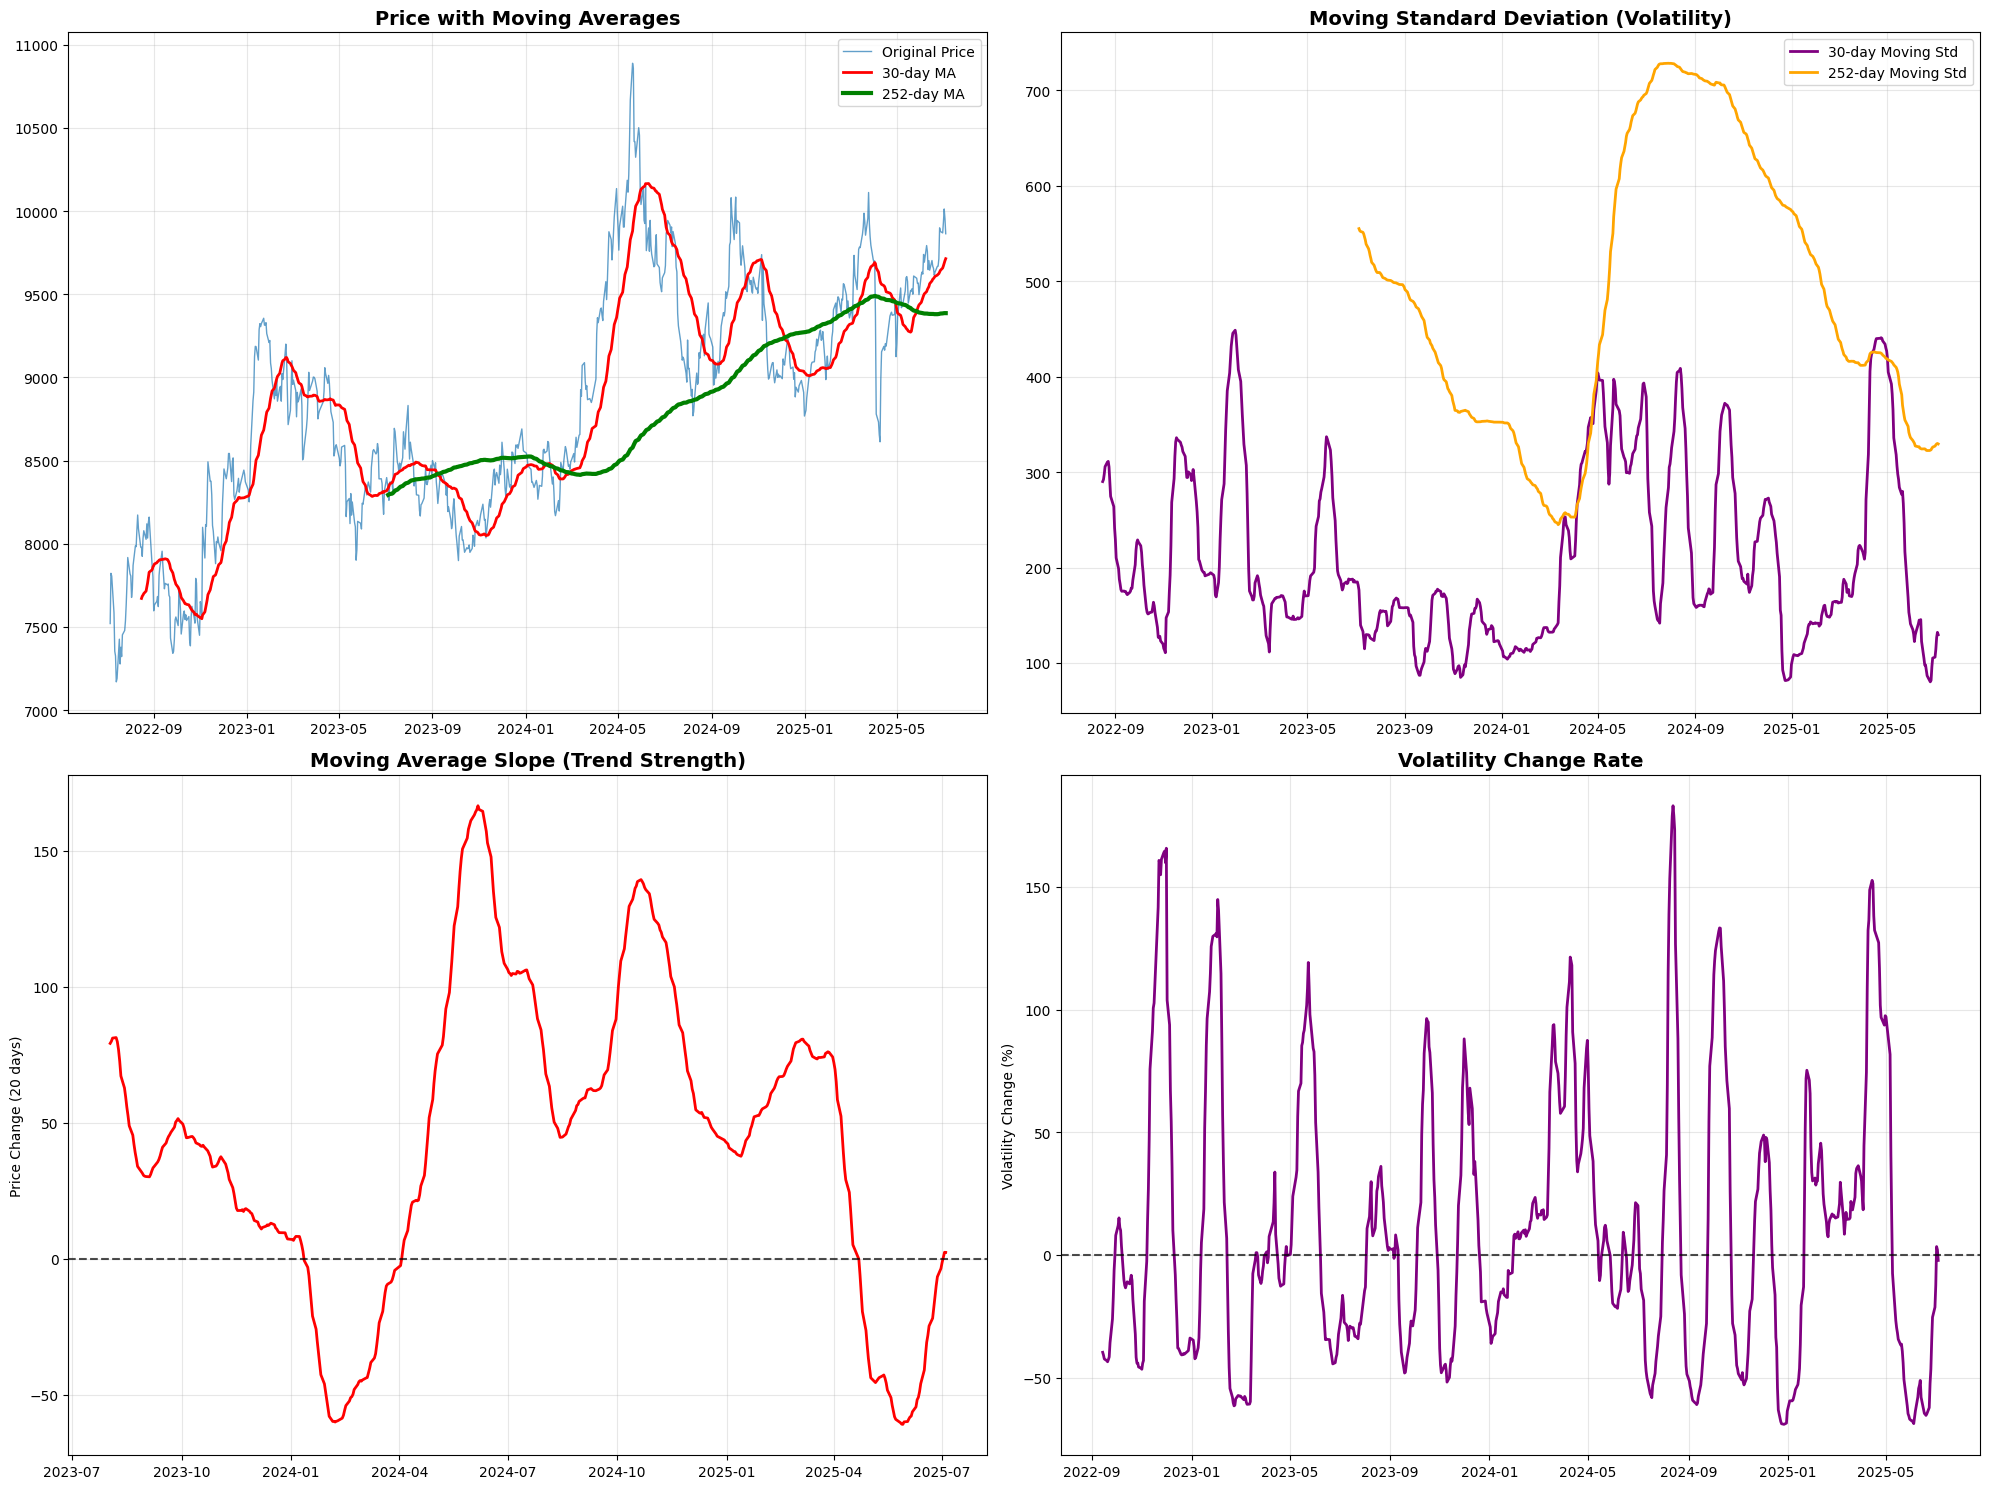

🔍 移動統計量の定量的解釈
📈 長期トレンド分析（252日移動平均）:
   開始価格: $8,294.01
   終了価格: $9,386.70
   総変化: +13.2%
   💡 解釈: 強い上昇トレンド → 非定常の可能性大

📊 ボラティリティ分析（252日移動標準偏差）:
   初期ボラティリティ: $498.69
   最近ボラティリティ: $372.32
   変化: -25.3%
   💡 解釈: ボラティリティが大きく変化 → 分散非定常の可能性

🎯 総合判定:
   ⚠️ 非定常性の兆候が強い → 差分変換が必要


In [3]:
# 移動統計量の計算と詳細解釈
if price_series is not None:
    # 移動統計量計算
    ma_30 = price_series.rolling(30).mean()
    ma_252 = price_series.rolling(252).mean()
    mstd_30 = price_series.rolling(30).std()
    mstd_252 = price_series.rolling(252).std()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 価格と移動平均
    ax1.plot(price_series.index, price_series, label='Original Price', alpha=0.7, linewidth=1)
    ax1.plot(ma_30.index, ma_30, label='30-day MA', linewidth=2, color='red')
    ax1.plot(ma_252.index, ma_252, label='252-day MA', linewidth=3, color='green')
    ax1.set_title('Price with Moving Averages', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 移動標準偏差（ボラティリティ）
    ax2.plot(mstd_30.index, mstd_30, label='30-day Moving Std', linewidth=2, color='purple')
    ax2.plot(mstd_252.index, mstd_252, label='252-day Moving Std', linewidth=2, color='orange')
    ax2.set_title('Moving Standard Deviation (Volatility)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 移動平均の傾き（トレンドの強さ）
    ma_slope = ma_252.diff(20)  # 20日前との差分
    ax3.plot(ma_slope.index, ma_slope, linewidth=2, color='red')
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    ax3.set_title('Moving Average Slope (Trend Strength)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Price Change (20 days)')
    ax3.grid(True, alpha=0.3)
    
    # 4. ボラティリティの変化率
    vol_change = mstd_30.pct_change(20)  # 20日前からの変化率
    ax4.plot(vol_change.index, vol_change * 100, linewidth=2, color='purple')
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    ax4.set_title('Volatility Change Rate', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Volatility Change (%)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 定量的な解釈
    print("🔍 移動統計量の定量的解釈")
    print("=" * 50)
    
    # トレンドの方向性
    trend_start = ma_252.dropna().iloc[0]
    trend_end = ma_252.dropna().iloc[-1]
    trend_change = (trend_end - trend_start) / trend_start * 100
    
    print(f"📈 長期トレンド分析（252日移動平均）:")
    print(f"   開始価格: ${trend_start:,.2f}")
    print(f"   終了価格: ${trend_end:,.2f}")
    print(f"   総変化: {trend_change:+.1f}%")
    
    if abs(trend_change) > 10:
        print(f"   💡 解釈: 強い{'上昇' if trend_change > 0 else '下降'}トレンド → 非定常の可能性大")
    else:
        print(f"   💡 解釈: 弱いトレンド → 定常の可能性あり")
    
    # ボラティリティの安定性
    vol_start = mstd_252.dropna().iloc[:63].mean()  # 最初の四半期
    vol_end = mstd_252.dropna().iloc[-63:].mean()   # 最後の四半期
    vol_change_pct = (vol_end - vol_start) / vol_start * 100
    
    print(f"\n📊 ボラティリティ分析（252日移動標準偏差）:")
    print(f"   初期ボラティリティ: ${vol_start:.2f}")
    print(f"   最近ボラティリティ: ${vol_end:.2f}")
    print(f"   変化: {vol_change_pct:+.1f}%")
    
    if abs(vol_change_pct) > 20:
        print(f"   💡 解釈: ボラティリティが大きく変化 → 分散非定常の可能性")
    else:
        print(f"   💡 解釈: ボラティリティは比較的安定 → 分散定常の可能性")
    
    print(f"\n🎯 総合判定:")
    if abs(trend_change) > 10 or abs(vol_change_pct) > 20:
        print("   ⚠️ 非定常性の兆候が強い → 差分変換が必要")
    else:
        print("   ✓ 定常性の可能性あり → ADF検定で確認")

## 📊 解釈2: ADF検定結果の詳細解釈

### 🔬 **ADF検定とは？**
**Augmented Dickey-Fuller検定**は、時系列に**単位根**があるかを検定します。

### 📋 **検定の仮説**
- **帰無仮説 (H₀)**: 単位根が存在する（非定常）
- **対立仮説 (H₁)**: 単位根が存在しない（定常）

### 📊 **結果の読み方**
1. **p値 < 0.05** → 帰無仮説棄却 → **定常**
2. **p値 ≥ 0.05** → 帰無仮説採択 → **非定常**
3. **ADF統計量 < 臨界値** → **定常性を支持**

### 💡 **トレーディングへの意味**
- **定常** → 価格は平均に回帰する傾向 → **平均回帰戦略**が有効
- **非定常** → 価格にトレンドあり → **トレンドフォロー戦略**が有効

In [4]:
# ADF検定の詳細解釈
def detailed_adf_interpretation(series, series_name):
    """ADF検定結果の詳細解釈と意味説明"""
    if not STATSMODELS_AVAILABLE:
        print("statsmodelsが利用できません")
        return
    
    result = adfuller(series.dropna(), autolag='AIC')
    
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    print(f"🔬 {series_name} ADF検定の詳細解釈")
    print("=" * 60)
    
    print(f"📊 検定統計量")
    print(f"   ADF統計量: {adf_stat:.6f}")
    print(f"   p値: {p_value:.6f}")
    
    print(f"\n📋 臨界値との比較")
    for level, critical_val in critical_values.items():
        if adf_stat < critical_val:
            result_text = "定常性を支持 ✓"
            color = "緑"
        else:
            result_text = "非定常性を示唆 ⚠️"
            color = "赤"
        print(f"   {level}水準: {critical_val:.4f} → {result_text}")
    
    print(f"\n🎯 統計的結論")
    alpha = 0.05
    if p_value <= alpha:
        print(f"   ✓ p値 ({p_value:.6f}) ≤ 0.05")
        print(f"   ✓ 帰無仮説を棄却: この時系列は**定常**です")
        stationarity = "定常"
        trading_implication = "平均回帰戦略"
    else:
        print(f"   ⚠️ p値 ({p_value:.6f}) > 0.05")
        print(f"   ⚠️ 帰無仮説を採択: この時系列は**非定常**です")
        stationarity = "非定常"
        trading_implication = "トレンドフォロー戦略"
    
    print(f"\n💰 トレーディングへの含意")
    if stationarity == "定常":
        print(f"   📈 **平均回帰戦略**が効果的:")
        print(f"      - 価格が平均から大きく乖離したら逆張り")
        print(f"      - ボリンジャーバンドなどの平均回帰指標が有効")
        print(f"      - 長期保有よりも短期売買が適している")
    else:
        print(f"   📈 **トレンドフォロー戦略**が効果的:")
        print(f"      - 価格トレンドに沿った順張り")
        print(f"      - 移動平均線ブレイクアウト戦略")
        print(f"      - モメンタム指標が有効")
    
    print(f"\n⚠️ 注意点")
    if stationarity == "非定常":
        print(f"   - 差分変換による定常化が必要")
        print(f"   - ARIMAモデルのd（差分次数）≥1")
        print(f"   - 長期予測は困難（ランダムウォーク特性）")
    else:
        print(f"   - ARモデルやMAモデルが適用可能")
        print(f"   - 長期予測の精度が期待できる")
    
    return {
        'statistic': adf_stat,
        'p_value': p_value,
        'is_stationary': p_value <= 0.05,
        'trading_strategy': trading_implication
    }

# 原系列のADF検定解釈
if price_series is not None:
    adf_original = detailed_adf_interpretation(price_series, "LME銅3M価格（原系列）")

🔬 LME銅3M価格（原系列） ADF検定の詳細解釈
📊 検定統計量
   ADF統計量: -2.254671
   p値: 0.187004

📋 臨界値との比較
   1%水準: -3.4390 → 非定常性を示唆 ⚠️
   5%水準: -2.8654 → 非定常性を示唆 ⚠️
   10%水準: -2.5688 → 非定常性を示唆 ⚠️

🎯 統計的結論
   ⚠️ p値 (0.187004) > 0.05
   ⚠️ 帰無仮説を採択: この時系列は**非定常**です

💰 トレーディングへの含意
   📈 **トレンドフォロー戦略**が効果的:
      - 価格トレンドに沿った順張り
      - 移動平均線ブレイクアウト戦略
      - モメンタム指標が有効

⚠️ 注意点
   - 差分変換による定常化が必要
   - ARIMAモデルのd（差分次数）≥1
   - 長期予測は困難（ランダムウォーク特性）


## 📊 解釈3: ACF/PACFチャートの読み方

### 🔍 **ACF（自己相関関数）とは？**
**ACF**は、時系列が**過去の自分自身**とどの程度相関しているかを示します。

### 🔍 **PACF（偏自己相関関数）とは？**
**PACF**は、**中間のラグの影響を除いた**直接的な相関を示します。

### 📈 **パターンの解釈**

#### **ACFパターン**
1. **緩やかに減衰** → トレンド/単位根の存在（非定常）
2. **急速に減衰** → 定常性あり
3. **q次で切れる** → MA(q)プロセス
4. **周期的パターン** → 季節性あり

#### **PACFパターン**
1. **p次で切れる** → AR(p)プロセス
2. **指数的減衰** → MAプロセス
3. **1次のみ有意** → AR(1)またはランダムウォーク

📊 LME銅3M価格（原系列） ACF/PACF解釈


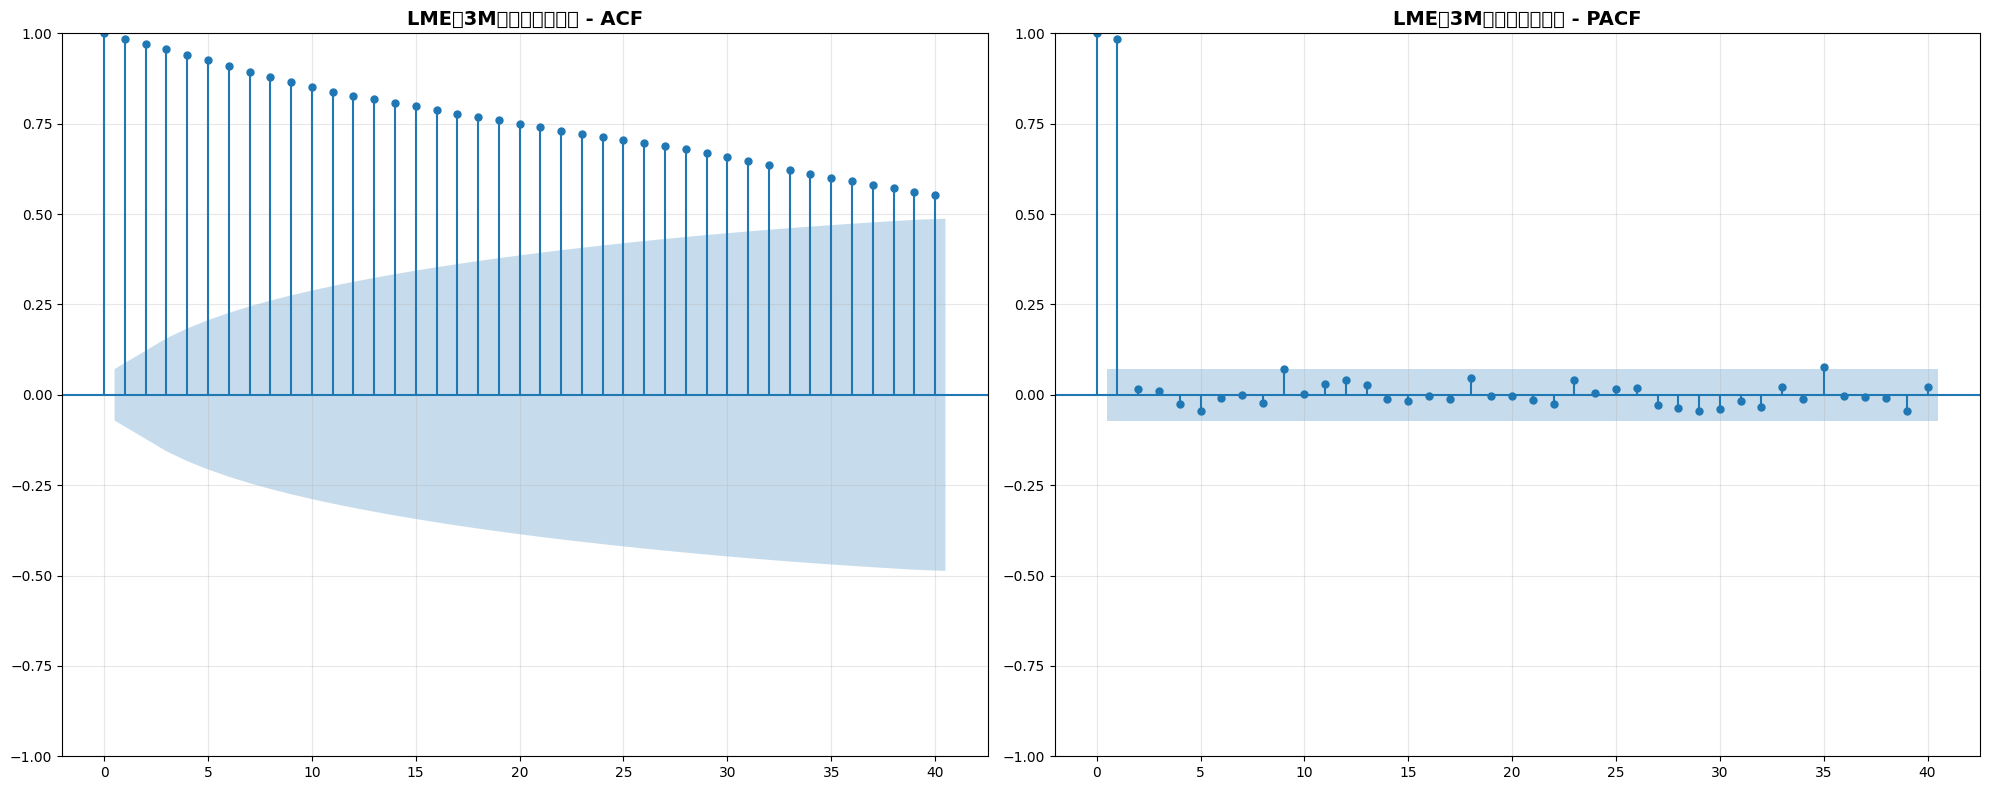

🔍 ACF分析
   1次ラグ自己相関: 0.9847
   10次ラグでの値: 0.8512
   パターン解釈: 緩やかに減衰（非定常の兆候）
   モデル示唆: 差分変換が必要

🔍 PACF分析
   1次偏自己相関: 0.9860
   有意なラグ数: 9
   モデル示唆: AR(9)成分

💰 トレーディング含意
   📈 強い自己相関 → **トレンドフォロー**戦略
      - 価格変動が持続しやすい
      - モメンタム指標が有効
      - ブレイクアウト戦略

📊 予測モデル推奨
   - AR(9)モデルから開始
   - 9期前の価格が予測に重要
   - 短期予測（9日程度）が有効


In [5]:
# ACF/PACFの詳細解釈
def interpret_acf_pacf(series, series_name, max_lags=40):
    """ACF/PACFの詳細解釈"""
    if not STATSMODELS_AVAILABLE:
        print("statsmodelsが利用できません")
        return
    
    print(f"📊 {series_name} ACF/PACF解釈")
    print("=" * 60)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # ACFプロット
    plot_acf(series.dropna(), ax=ax1, lags=max_lags, alpha=0.05)
    ax1.set_title(f'{series_name} - ACF', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # PACFプロット
    plot_pacf(series.dropna(), ax=ax2, lags=max_lags, alpha=0.05)
    ax2.set_title(f'{series_name} - PACF', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 自己相関の計算と解釈
    from statsmodels.tsa.stattools import acf, pacf
    
    acf_values = acf(series.dropna(), nlags=20, alpha=0.05)
    pacf_values = pacf(series.dropna(), nlags=20, alpha=0.05)
    
    print(f"🔍 ACF分析")
    print(f"   1次ラグ自己相関: {acf_values[0][1]:.4f}")
    
    # ACFの減衰パターン判定
    acf_10 = acf_values[0][10]
    if acf_10 > 0.5:
        acf_pattern = "緩やかに減衰（非定常の兆候）"
        model_suggestion = "差分変換が必要"
    elif acf_10 > 0.1:
        acf_pattern = "中程度の減衰（弱い持続性）"
        model_suggestion = "AR成分を含むモデル"
    else:
        acf_pattern = "急速に減衰（定常性の兆候）"
        model_suggestion = "定常モデル適用可能"
    
    print(f"   10次ラグでの値: {acf_10:.4f}")
    print(f"   パターン解釈: {acf_pattern}")
    print(f"   モデル示唆: {model_suggestion}")
    
    print(f"\n🔍 PACF分析")
    pacf_1 = pacf_values[0][1]
    print(f"   1次偏自己相関: {pacf_1:.4f}")
    
    # 有意なPACFラグ数をカウント
    significant_lags = 0
    confidence_upper = pacf_values[1][:10, 1] - pacf_values[0][:10]
    
    for i in range(1, min(10, len(pacf_values[0]))):
        if abs(pacf_values[0][i]) > confidence_upper[i]:
            significant_lags = i
    
    if significant_lags > 0:
        print(f"   有意なラグ数: {significant_lags}")
        print(f"   モデル示唆: AR({significant_lags})成分")
    else:
        print(f"   有意なラグ: なし")
        print(f"   モデル示唆: ホワイトノイズまたはMA成分")
    
    # トレーディング含意
    print(f"\n💰 トレーディング含意")
    if acf_10 > 0.3:
        print(f"   📈 強い自己相関 → **トレンドフォロー**戦略")
        print(f"      - 価格変動が持続しやすい")
        print(f"      - モメンタム指標が有効")
        print(f"      - ブレイクアウト戦略")
    else:
        print(f"   📈 弱い自己相関 → **平均回帰**戦略")
        print(f"      - 価格変動は短期的")
        print(f"      - オシレーター指標が有効")
        print(f"      - レンジ取引戦略")
    
    if significant_lags > 0:
        print(f"\n📊 予測モデル推奨")
        print(f"   - AR({significant_lags})モデルから開始")
        print(f"   - {significant_lags}期前の価格が予測に重要")
        print(f"   - 短期予測（{significant_lags}日程度）が有効")

# 原系列のACF/PACF解釈
if price_series is not None:
    interpret_acf_pacf(price_series, "LME銅3M価格（原系列）")

## 📊 解釈4: 差分系列の意味とトレーディング活用

### 🔄 **差分変換とは？**
**1階差分**: 今日の価格 - 昨日の価格 = 日次価格変化
**対数差分**: log(今日の価格) - log(昨日の価格) = 日次リターン

### 📊 **差分系列の特徴**
1. **平均**: 平均的な日次変化（ドリフト）
2. **標準偏差**: 日次ボラティリティ
3. **歪度**: リターン分布の非対称性
4. **尖度**: 極端なリターンの頻度

### 💡 **トレーディングへの活用**
- **正の平均**: 長期的上昇バイアス
- **高い標準偏差**: 高ボラティリティ → リスク管理重要
- **負の歪度**: 大きな下落リスク
- **高い尖度**: "ファットテール" → 極端な動きが多い

In [6]:
# 差分系列の詳細解釈
if price_series is not None:
    # 差分系列の計算
    price_diff = price_series.diff().dropna()
    log_price = np.log(price_series)
    log_returns = log_price.diff().dropna()
    
    print("🔄 差分系列の詳細解釈")
    print("=" * 60)
    
    # 統計量の計算
    from scipy import stats
    
    # 価格差分の統計
    print(f"📊 価格差分（日次価格変化）の統計")
    print(f"   平均: ${price_diff.mean():.2f}/日")
    print(f"   標準偏差: ${price_diff.std():.2f}/日")
    print(f"   年率換算標準偏差: ${price_diff.std() * np.sqrt(252):.2f}/年")
    print(f"   最大上昇: ${price_diff.max():.2f}")
    print(f"   最大下落: ${price_diff.min():.2f}")
    
    # 対数リターンの統計
    print(f"\n📊 対数リターン（日次リターン）の統計")
    print(f"   平均: {log_returns.mean():.6f} ({log_returns.mean()*100:.4f}%/日)")
    print(f"   標準偏差: {log_returns.std():.6f} ({log_returns.std()*100:.4f}%/日)")
    print(f"   年率リターン: {log_returns.mean()*252*100:.2f}%")
    print(f"   年率ボラティリティ: {log_returns.std()*np.sqrt(252)*100:.2f}%")
    
    # 分布の特性
    skewness = stats.skew(log_returns)
    kurtosis = stats.kurtosis(log_returns)
    
    print(f"\n📈 分布の特性")
    print(f"   歪度: {skewness:.4f}")
    print(f"   尖度: {kurtosis:.4f}")
    
    # 歪度の解釈
    if skewness < -0.5:
        skew_interpretation = "強い負の歪み → 大きな下落リスク"
        skew_trading = "下方リスクを重視した戦略"
    elif skewness > 0.5:
        skew_interpretation = "強い正の歪み → 大きな上昇機会"
        skew_trading = "上昇トレンドを狙った戦略"
    else:
        skew_interpretation = "ほぼ対称的な分布"
        skew_trading = "対称的なリスク・リターン"
    
    print(f"   解釈: {skew_interpretation}")
    
    # 尖度の解釈
    if kurtosis > 3:
        kurt_interpretation = "ファットテール → 極端な動きが多い"
        kurt_trading = "リスク管理を強化"
    else:
        kurt_interpretation = "正規分布に近い"
        kurt_trading = "標準的なリスク管理"
    
    print(f"   解釈: {kurt_interpretation}")
    
    # VaRの計算
    var_95 = np.percentile(log_returns, 5)
    var_99 = np.percentile(log_returns, 1)
    
    print(f"\n⚠️ リスク指標")
    print(f"   VaR (95%): {var_95*100:.3f}% (日次)")
    print(f"   VaR (99%): {var_99*100:.3f}% (日次)")
    print(f"   VaR (95%, 年率): {var_95*np.sqrt(252)*100:.1f}%")
    
    # トレーディング含意
    print(f"\n💰 トレーディング含意")
    
    annual_return = log_returns.mean() * 252 * 100
    annual_vol = log_returns.std() * np.sqrt(252) * 100
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    
    print(f"📊 リスク・リターン特性:")
    print(f"   年率リターン: {annual_return:.1f}%")
    print(f"   年率ボラティリティ: {annual_vol:.1f}%")
    print(f"   シャープレシオ: {sharpe_ratio:.3f}")
    
    if annual_return > 0:
        print(f"   💡 正のドリフト → 長期的上昇バイアス")
        print(f"      - バイ&ホールド戦略が有効")
        print(f"      - 押し目買い戦略")
    else:
        print(f"   💡 負のドリフト → 長期的下降バイアス")
        print(f"      - ショートバイアス戦略")
        print(f"      - 戻り売り戦略")
    
    if annual_vol > 25:
        print(f"   ⚠️ 高ボラティリティ → リスク管理重要")
        print(f"      - 小さなポジションサイズ")
        print(f"      - タイトなストップロス")
        print(f"      - 短期取引中心")
    else:
        print(f"   ✓ 中程度ボラティリティ → 標準的リスク管理")
        print(f"      - 通常のポジションサイズ")
        print(f"      - 中長期取引可能")
    
    print(f"\n🎯 推奨ポジションサイズ計算")
    # Kelly Criterionに基づく推奨ポジションサイズ
    if annual_vol > 0:
        kelly_fraction = annual_return / (annual_vol ** 2) * 100
        print(f"   Kelly基準: {kelly_fraction:.1f}% (理論最適)")
        print(f"   推奨実用: {kelly_fraction/4:.1f}% (Kelly/4 - 実践的)")
        
        # リスクベースのポジションサイズ
        daily_risk_1pct = 0.01 / abs(var_95)  # 1%リスクでのポジションサイズ
        print(f"   1%VaRベース: {daily_risk_1pct:.1f}% (資本の1%リスク)")

🔄 差分系列の詳細解釈
📊 価格差分（日次価格変化）の統計
   平均: $3.10/日
   標準偏差: $108.63/日
   年率換算標準偏差: $1724.46/年
   最大上昇: $538.00
   最大下落: $-586.50

📊 対数リターン（日次リターン）の統計
   平均: 0.000358 (0.0358%/日)
   標準偏差: 0.012353 (1.2353%/日)
   年率リターン: 9.03%
   年率ボラティリティ: 19.61%

📈 分布の特性
   歪度: -0.0818
   尖度: 2.6357
   解釈: ほぼ対称的な分布
   解釈: 正規分布に近い

⚠️ リスク指標
   VaR (95%): -1.971% (日次)
   VaR (99%): -3.442% (日次)
   VaR (95%, 年率): -31.3%

💰 トレーディング含意
📊 リスク・リターン特性:
   年率リターン: 9.0%
   年率ボラティリティ: 19.6%
   シャープレシオ: 0.460
   💡 正のドリフト → 長期的上昇バイアス
      - バイ&ホールド戦略が有効
      - 押し目買い戦略
   ✓ 中程度ボラティリティ → 標準的リスク管理
      - 通常のポジションサイズ
      - 中長期取引可能

🎯 推奨ポジションサイズ計算
   Kelly基準: 2.3% (理論最適)
   推奨実用: 0.6% (Kelly/4 - 実践的)
   1%VaRベース: 0.5% (資本の1%リスク)


## 📊 解釈5: 差分系列の定常性確認


🔬 価格差分系列 ADF検定の詳細解釈
📊 検定統計量
   ADF統計量: -27.535387
   p値: 0.000000

📋 臨界値との比較
   1%水準: -3.4390 → 定常性を支持 ✓
   5%水準: -2.8654 → 定常性を支持 ✓
   10%水準: -2.5688 → 定常性を支持 ✓

🎯 統計的結論
   ✓ p値 (0.000000) ≤ 0.05
   ✓ 帰無仮説を棄却: この時系列は**定常**です

💰 トレーディングへの含意
   📈 **平均回帰戦略**が効果的:
      - 価格が平均から大きく乖離したら逆張り
      - ボリンジャーバンドなどの平均回帰指標が有効
      - 長期保有よりも短期売買が適している

⚠️ 注意点
   - ARモデルやMAモデルが適用可能
   - 長期予測の精度が期待できる

🔬 対数リターン系列 ADF検定の詳細解釈
📊 検定統計量
   ADF統計量: -27.647820
   p値: 0.000000

📋 臨界値との比較
   1%水準: -3.4390 → 定常性を支持 ✓
   5%水準: -2.8654 → 定常性を支持 ✓
   10%水準: -2.5688 → 定常性を支持 ✓

🎯 統計的結論
   ✓ p値 (0.000000) ≤ 0.05
   ✓ 帰無仮説を棄却: この時系列は**定常**です

💰 トレーディングへの含意
   📈 **平均回帰戦略**が効果的:
      - 価格が平均から大きく乖離したら逆張り
      - ボリンジャーバンドなどの平均回帰指標が有効
      - 長期保有よりも短期売買が適している

⚠️ 注意点
   - ARモデルやMAモデルが適用可能
   - 長期予測の精度が期待できる

📊 対数リターン系列 ACF/PACF解釈


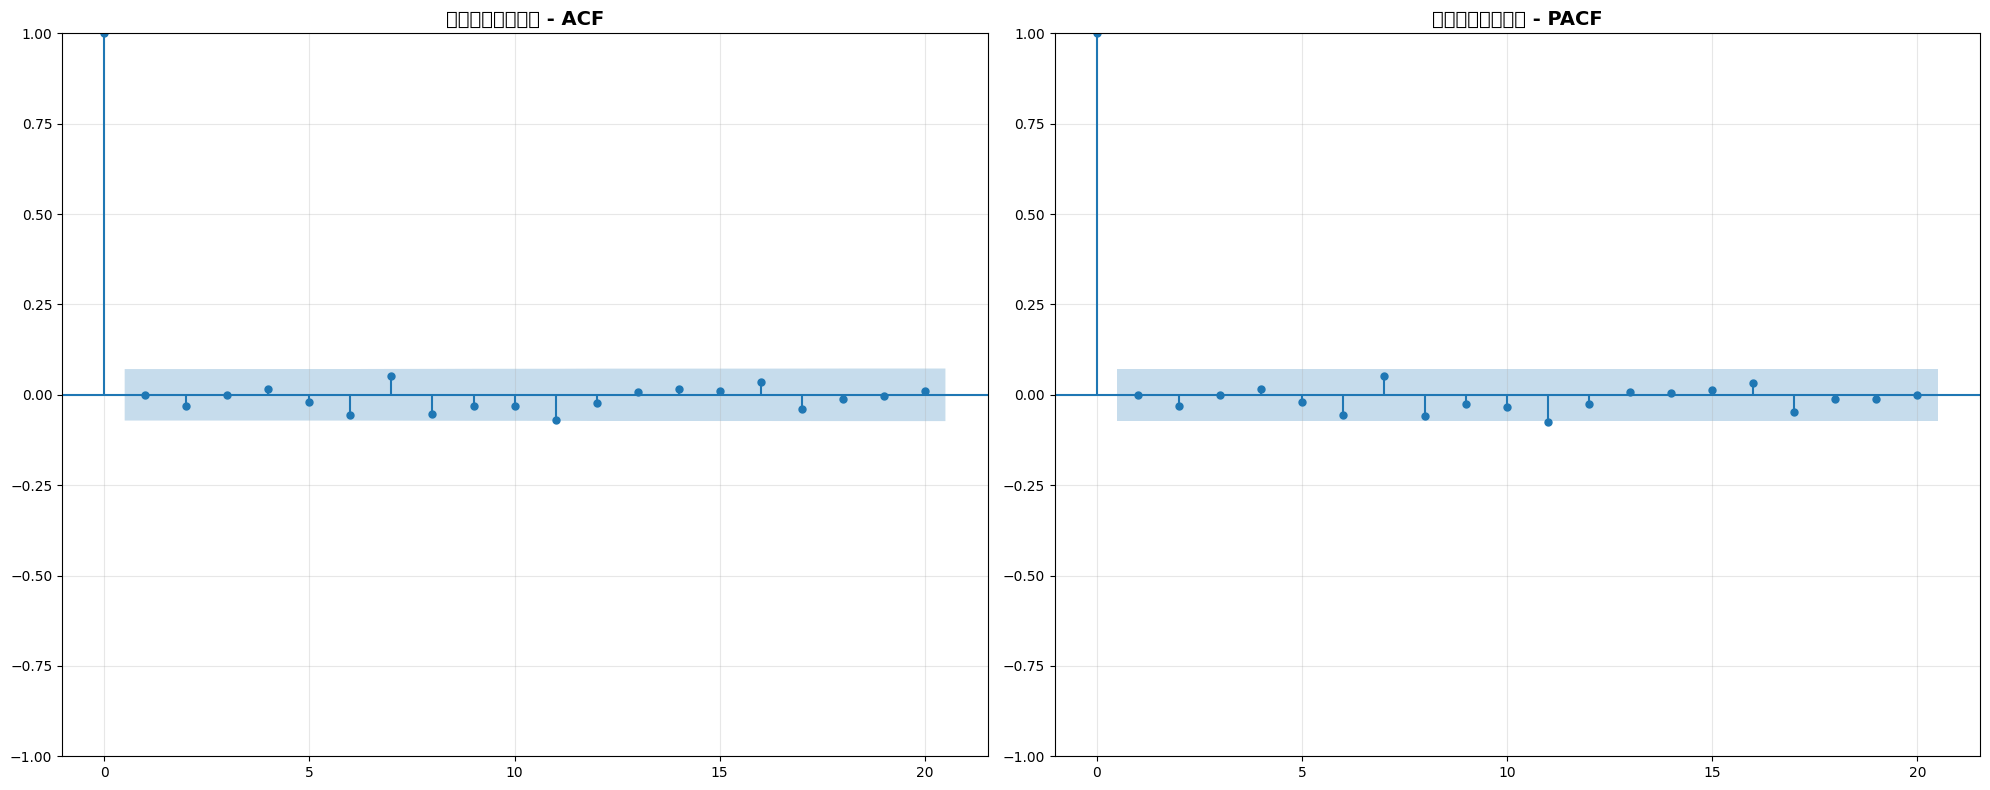

🔍 ACF分析
   1次ラグ自己相関: -0.0006
   10次ラグでの値: -0.0317
   パターン解釈: 急速に減衰（定常性の兆候）
   モデル示唆: 定常モデル適用可能

🔍 PACF分析
   1次偏自己相関: -0.0006
   有意なラグ: なし
   モデル示唆: ホワイトノイズまたはMA成分

💰 トレーディング含意
   📈 弱い自己相関 → **平均回帰**戦略
      - 価格変動は短期的
      - オシレーター指標が有効
      - レンジ取引戦略


In [7]:
# 差分系列の定常性確認
if price_series is not None and STATSMODELS_AVAILABLE:
    print("\n" + "="*60)
    adf_diff = detailed_adf_interpretation(price_diff, "価格差分系列")
    
    print("\n" + "="*60)
    adf_returns = detailed_adf_interpretation(log_returns, "対数リターン系列")
    
    # 差分系列のACF/PACF
    print("\n" + "="*60)
    interpret_acf_pacf(log_returns, "対数リターン系列", max_lags=20)

## 🎯 総合解釈とトレーディング戦略

### 📊 **分析結果の統合**
ここまでの分析結果を統合して、実際のトレーディング戦略を構築します。

In [8]:
# 総合的な戦略提案
print("🎯 LME銅3M 総合トレーディング戦略")
print("=" * 80)

if price_series is not None:
    # 最新の市場状況
    latest_price = price_series.iloc[-1]
    ma_30_latest = price_series.rolling(30).mean().iloc[-1]
    ma_252_latest = price_series.rolling(252).mean().iloc[-1]
    
    current_vol = log_returns.tail(30).std() * np.sqrt(252) * 100
    avg_vol = log_returns.std() * np.sqrt(252) * 100
    
    print(f"📈 現在の市場状況")
    print(f"   最新価格: ${latest_price:,.2f}")
    print(f"   30日移動平均: ${ma_30_latest:,.2f}")
    print(f"   252日移動平均: ${ma_252_latest:,.2f}")
    print(f"   現在ボラティリティ: {current_vol:.1f}%")
    print(f"   平均ボラティリティ: {avg_vol:.1f}%")
    
    # トレンド判定
    if latest_price > ma_252_latest:
        long_term_trend = "上昇トレンド"
        trend_strategy = "買いバイアス"
    else:
        long_term_trend = "下降トレンド"
        trend_strategy = "売りバイアス"
    
    if latest_price > ma_30_latest:
        short_term_trend = "短期上昇"
    else:
        short_term_trend = "短期下降"
    
    print(f"\n📊 トレンド分析")
    print(f"   長期トレンド: {long_term_trend}")
    print(f"   短期トレンド: {short_term_trend}")
    print(f"   基本戦略: {trend_strategy}")
    
    # ボラティリティ状況
    if current_vol > avg_vol * 1.3:
        vol_status = "高ボラティリティ期間"
        vol_strategy = "リスク縮小・短期取引"
    elif current_vol < avg_vol * 0.7:
        vol_status = "低ボラティリティ期間"
        vol_strategy = "リスク拡大・長期取引"
    else:
        vol_status = "通常ボラティリティ期間"
        vol_strategy = "標準戦略"
    
    print(f"\n📊 ボラティリティ状況")
    print(f"   現在状況: {vol_status}")
    print(f"   適用戦略: {vol_strategy}")
    
    # 具体的な取引推奨
    print(f"\n💰 具体的取引推奨")
    
    # エントリーレベル
    atr_30 = price_series.diff().abs().rolling(30).mean().iloc[-1]
    
    if trend_strategy == "買いバイアス":
        entry_level = ma_30_latest - atr_30 * 0.5
        stop_level = latest_price - atr_30 * 2
        target_level = latest_price + atr_30 * 3
        
        print(f"   🔵 買い戦略:")
        print(f"      押し目買いレベル: ${entry_level:,.2f}")
        print(f"      ストップロス: ${stop_level:,.2f}")
        print(f"      利食い目標: ${target_level:,.2f}")
    else:
        entry_level = ma_30_latest + atr_30 * 0.5
        stop_level = latest_price + atr_30 * 2
        target_level = latest_price - atr_30 * 3
        
        print(f"   🔴 売り戦略:")
        print(f"      戻り売りレベル: ${entry_level:,.2f}")
        print(f"      ストップロス: ${stop_level:,.2f}")
        print(f"      利食い目標: ${target_level:,.2f}")
    
    # リスク管理
    risk_per_trade = abs(latest_price - stop_level) / latest_price
    recommended_size = 0.02 / risk_per_trade  # 2%リスクでのポジションサイズ
    
    print(f"\n⚠️ リスク管理")
    print(f"   1トレードリスク: {risk_per_trade*100:.2f}%")
    print(f"   推奨ポジションサイズ: {recommended_size:.1f}% (資本の2%リスク)")
    print(f"   最大同時ポジション: 3個 (6%総リスク)")
    
    # 時間軸別戦略
    print(f"\n⏰ 時間軸別戦略")
    if current_vol > avg_vol * 1.3:
        print(f"   短期 (1-5日): スキャルピング・デイトレード")
        print(f"   中期 (1-2週): 避ける")
        print(f"   長期 (1ヶ月+): 避ける")
    else:
        print(f"   短期 (1-5日): モメンタム取引")
        print(f"   中期 (1-2週): トレンドフォロー")
        print(f"   長期 (1ヶ月+): ポジション取引")
    
    print(f"\n🚨 注意事項")
    print(f"   - 経済指標発表時は取引を控える")
    print(f"   - 中国の経済データに特に注意")
    print(f"   - 流動性の低い時間帯は避ける")
    print(f"   - ポジションサイズは厳守する")
    
    print(f"\n{'='*80}")
    print(f"分析完了: 時系列分析に基づく包括的トレーディング戦略")
    print(f"{'='*80}")

🎯 LME銅3M 総合トレーディング戦略
📈 現在の市場状況
   最新価格: $9,864.00
   30日移動平均: $9,714.12
   252日移動平均: $9,386.70
   現在ボラティリティ: 11.4%
   平均ボラティリティ: 19.6%

📊 トレンド分析
   長期トレンド: 上昇トレンド
   短期トレンド: 短期上昇
   基本戦略: 買いバイアス

📊 ボラティリティ状況
   現在状況: 低ボラティリティ期間
   適用戦略: リスク拡大・長期取引

💰 具体的取引推奨
   🔵 買い戦略:
      押し目買いレベル: $9,686.61
      ストップロス: $9,753.97
      利食い目標: $10,029.05

⚠️ リスク管理
   1トレードリスク: 1.12%
   推奨ポジションサイズ: 1.8% (資本の2%リスク)
   最大同時ポジション: 3個 (6%総リスク)

⏰ 時間軸別戦略
   短期 (1-5日): モメンタム取引
   中期 (1-2週): トレンドフォロー
   長期 (1ヶ月+): ポジション取引

🚨 注意事項
   - 経済指標発表時は取引を控える
   - 中国の経済データに特に注意
   - 流動性の低い時間帯は避ける
   - ポジションサイズは厳守する

分析完了: 時系列分析に基づく包括的トレーディング戦略
